In [ ]:
!pip install bsk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.3
    Uninstalling tqdm-4.67.3:
      Successfully uninstalled tqdm-4.67.3
  Attempting uninstall: pooch
    Found existing installation: pooch 1.9.0
    Uninstalling pooch-1.9.0:
      Successfully uninstalled pooch-1.9.0


In [ ]:
#
#  ISC License
#
#  Copyright (c) 2016, Autonomous Vehicle Systems Lab, University of Colorado at Boulder
#
#  Permission to use, copy, modify, and/or distribute this software for any
#  purpose with or without fee is hereby granted, provided that the above
#  copyright notice and this permission notice appear in all copies.
#
#  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES
#  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF
#  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR
#  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
#  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
#  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
#  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
#

r"""
Overview
--------

This is an illustration of how to use simplePower modules to perform orbit power analysis considering
attitude and orbital coupling.

This scenario is intended to provide both an overview and a concrete demonstration of the features and interface of the
:ref:`Folder_power` group of modules, which represent Basilisk's low-fidelity power system modeling functionality. Specifically,
simplePower modules are intended to provide three major features:

#. Computation of power generated by solar panels, which considers orbit and attitude dependence;
#. Computation of power consumed by on-board spacecraft power sinks;
#. Computation of the spacecraft power balance and total stored energy by the simpleBattery class.

The script is found in the folder ``basilisk/examples`` and executed by using::

      python3 scenarioPowerDemo.py

The simplePower subsystem consists of two kinds of Basilisk simModules: :ref:`powerStorageBase` (which is used to represent
power storage units, and serves as the heart of the subsystem) and :ref:`powerNodeBase` (which is used to represent system
components that consume or generate power). A conceptual diagram of these classes and their interfaces to eachother
and the rest of Basilisk is shown in the figure below.

.. image:: /_images/static/simplePowerConcept.svg
   :width: 450px
   :align: center

In general, this system can be configured using the following process:

#. Create and configure a set of powerNodeBase modules to represent power system sources and sinks,
   including their ``nodePowerOutMsg`` attributes;
#. Create and configure a :ref:`powerStorageBase` instance;
#. Use the ``addPowerNodeToModel()`` method from the :ref:`powerStorageBase` on the ``nodePowerOutMsg``
   you configured in step 1 to link the power nodes to the :ref:`powerStorageBase` instance
#. Run the simulation.

One version of this process is demonstrated here. A spacecraft representing a tumbling 6U cubesat
is placed in a LEO orbit,
using methods that are described in other scenarios. Three simplePower modules are created:
a :ref:`simpleBattery`, a :ref:`simpleSolarPanel`,
and a :ref:`simplePowerSink` (which represents the load demanded by on-board electronics.)
The solar panel is assumed to be body-fixed,
and given the parameters appropriate for a 6U cubesat.

When the simulation completes, the following single plot is shown to
demonstrate the panel's attitude and orbit dependence,
the net power generated, the stored power, and the power consumed. An initial rise in net power from the panel
facing towards the sun is cut short as the spacecraft enters eclipse; as it exits, the stored charge of the
battery begins to rebuild.

.. image:: /_images/Scenarios/scenario_powerDemo.svg
   :align: center

"""

import inspect
import os

import numpy as np
from matplotlib import pyplot as plt

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.path.dirname(os.path.abspath(filename))
bskName = 'Basilisk'
splitPath = path.split(bskName)

# Import all of the modules that we are going to be called in this simulation
from Basilisk.utilities import SimulationBaseClass
from Basilisk.simulation import simplePowerSink
from Basilisk.simulation import simpleBattery
from Basilisk.simulation import simpleSolarPanel
from Basilisk.simulation import eclipse
from Basilisk.simulation import spacecraft
from Basilisk.utilities import macros
from Basilisk.utilities import orbitalMotion
from Basilisk.utilities import simIncludeGravBody
from Basilisk.architecture import astroConstants
from Basilisk.utilities import vizSupport

# from Basilisk import __path__
# bskPath = __path__[0]

# path = os.path.dirname(os.path.abspath(__file__))

def run(show_plots):
    """
    The scenarios can be run with the followings setups parameters:

    Args:
        show_plots (bool): Determines if the script should display plots

    """
    taskName = "unitTask"               # arbitrary name (don't change)
    processname = "TestProcess"         # arbitrary name (don't change)

    # Create a sim module as an empty container
    scenarioSim = SimulationBaseClass.SimBaseClass()

    # Create test thread
    testProcessRate = macros.sec2nano(10.0)     # update process rate update time
    testProc = scenarioSim.CreateNewProcess(processname)
    testProc.addTask(scenarioSim.CreateNewTask(taskName, testProcessRate))

    # Create a spacecraft around Earth
    # initialize spacecraft object and set properties
    scObject = spacecraft.Spacecraft()
    scObject.ModelTag = "bsk-Sat"

    # clear prior gravitational body and SPICE setup definitions
    gravFactory = simIncludeGravBody.gravBodyFactory()

    planet = gravFactory.createEarth()
    planet.isCentralBody = True          # ensure this is the central gravitational body
    mu = planet.mu
    sun = gravFactory.createSun()
    # attach gravity model to spacecraft
    gravFactory.addBodiesTo(scObject)

    # setup Spice interface for some solar system bodies
    timeInitString = '2021 MAY 04 07:47:48.965 (UTC)'
    spiceObject = gravFactory.createSpiceInterface(time=timeInitString)
    scenarioSim.AddModelToTask(taskName, spiceObject, -1)

    # store planet and sun msgs
    plMsg = spiceObject.planetStateOutMsgs[0]
    sunMsg = spiceObject.planetStateOutMsgs[1]

    #   setup orbit using orbitalMotion library
    oe = orbitalMotion.ClassicElements()
    oe.a = astroConstants.REQ_EARTH*1e3 + 400e3
    oe.e = 0.0
    oe.i = 0.0*macros.D2R

    oe.Omega = 0.0*macros.D2R
    oe.omega = 0.0*macros.D2R
    oe.f     = 75.0*macros.D2R
    rN, vN = orbitalMotion.elem2rv(mu, oe)

    n = np.sqrt(mu/oe.a/oe.a/oe.a)
    P = 2.*np.pi/n

    scObject.hub.r_CN_NInit = rN
    scObject.hub.v_CN_NInit = vN

    scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
    scObject.hub.omega_BN_BInit = [[0.001], [-0.001], [0.001]]
    scenarioSim.AddModelToTask(taskName, scObject)

    #   Create an eclipse object so the panels don't always work
    eclipseObject = eclipse.Eclipse()
    eclipseObject.addSpacecraftToModel(scObject.scStateOutMsg)
    eclipseObject.addPlanetToModel(plMsg)
    eclipseObject.sunInMsg.subscribeTo(sunMsg)
    scenarioSim.AddModelToTask(taskName, eclipseObject)

    # Create a solar panel
    solarPanel1 = simpleSolarPanel.SimpleSolarPanel()
    solarPanel1.ModelTag = "solarPanel1"
    solarPanel1.stateInMsg.subscribeTo(scObject.scStateOutMsg)
    solarPanel1.sunEclipseInMsg.subscribeTo(eclipseObject.eclipseOutMsgs[0])
    solarPanel1.sunInMsg.subscribeTo(sunMsg)
    solarPanel1.setPanelParameters([1,0,0], 0.2*0.3, 0.20) # Set the panel normal vector in the body frame, the area, and efficiency
    # scenarioSim.AddModelToTask(taskName, solarPanel1)
    # solarPanel2 = simpleSolarPanel.SimpleSolarPanel()
    # solarPanel2.ModelTag = "solarPanel2"
    # solarPanel2.stateInMsg.subscribeTo(scObject.scStateOutMsg)
    # solarPanel2.sunEclipseInMsg.subscribeTo(eclipseObject.eclipseOutMsgs[0])
    # solarPanel2.sunInMsg.subscribeTo(sunMsg)
    # solarPanel2.setPanelParameters([-1,0,0], 0.2*0.3, 0.20) # this solar panel is on the opposite side of the satellite
    # scenarioSim.AddModelToTask(taskName, solarPanel2)

    #   Create a simple power sink
    powerSink = simplePowerSink.SimplePowerSink()
    powerSink.ModelTag = "powerSink2"
    powerSink.nodePowerOut = -3.  # Watts
    scenarioSim.AddModelToTask(taskName, powerSink)

    # Create a simpleBattery and attach the sources/sinks to it
    powerMonitor = simpleBattery.SimpleBattery()
    powerMonitor.ModelTag = "powerMonitor"
    powerMonitor.storageCapacity = 10.0 * 3600.0  # Convert from W-hr to Joules
    powerMonitor.storedCharge_Init = 10.0 * 3600.0  # Convert from W-Hr to Joules
    powerMonitor.addPowerNodeToModel(solarPanel1.nodePowerOutMsg)
    # powerMonitor.addPowerNodeToModel(solarPanel2.nodePowerOutMsg)
    powerMonitor.addPowerNodeToModel(powerSink.nodePowerOutMsg)
    scenarioSim.AddModelToTask(taskName, powerMonitor)

    # Setup logging on the power system
    spLog = solarPanel1.nodePowerOutMsg.recorder()
    # spLog = solarPanel2.nodePowerOutMsg.recorder()
    psLog = powerSink.nodePowerOutMsg.recorder()
    pmLog = powerMonitor.batPowerOutMsg.recorder()
    scenarioSim.AddModelToTask(taskName, spLog)
    scenarioSim.AddModelToTask(taskName, psLog)
    scenarioSim.AddModelToTask(taskName, pmLog)

    # used to visualize the orbit
    viz = vizSupport.enableUnityVisualization(scenarioSim, "unitTask", scObject, saveFile="mySimData.bin")

    # Need to call the self-init and cross-init methods
    scenarioSim.InitializeSimulation()

    # Set the simulation time.
    # NOTE: the total simulation time may be longer than this value. The
    # simulation is stopped at the next logging event on or after the
    # simulation end time.
    scenarioSim.ConfigureStopTime(macros.sec2nano(15*P))        # the simulation is run over the course of 15 orbital periods

    # Begin the simulation time run set above
    scenarioSim.ExecuteSimulation()

    # This pulls the actual data log from the simulation run.
    # Note that range(3) will provide [0, 1, 2]  Those are the elements you get from the vector (all of them)
    supplyData = spLog.netPower
    sinkData = psLog.netPower
    storageData = pmLog.storageLevel
    netData = pmLog.currentNetPower

    tvec = spLog.times()
    tvec = tvec * macros.NANO2HOUR

    #   Plot the power states
    figureList = {}
    plt.close("all")  # clears out plots from earlier test runs
    plt.figure(1)
    plt.plot(tvec, storageData/3600., label='Stored Power (W-Hr)')
    plt.plot(tvec, netData, label='Net Power (W)')
    plt.plot(tvec, supplyData, label='Panel Power (W)')
    plt.plot(tvec, sinkData, label='Power Draw (W)')
    plt.xlabel('Time (Hr)')
    plt.ylabel('Power (W)')
    plt.grid(True)
    plt.legend()

    pltName = "scenario_powerDemo"
    figureList[pltName] = plt.figure(1)

    if show_plots:
        plt.show()
    plt.close("all")

    return figureList

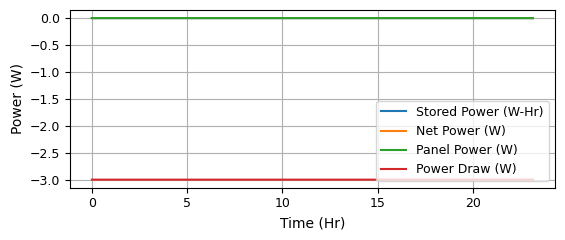

{'scenario_powerDemo': <Figure size 575x250 with 1 Axes>}

In [ ]:
run(True)